In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
from scipy.fft import fft, fftfreq


# Impulse response of FB network and how it changes with w and tau (from Jenny's paper)

In [2]:

home = os.path.expanduser("~")


sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG


In [3]:
#make impulse stimulus
def impulse_stimulus(length = 1.,impulse_timepoint = 0, amplitude = 1, dt = 0.001):


    tps = int(length/dt)
    barstim = np.zeros(tps)


    impulse_idx = int(impulse_timepoint/dt)
    barstim[impulse_idx] = amplitude

    #timeline = np.arange(0,length,self.dt)

    return barstim


def step_stimulus(length = 5.,start = 1.0, stop = 3.0, amplitude = 1, dt = 0.001):



    stimulus = (np.heaviside(np.arange(-start,length - start, dt), 1) - 1 * np.heaviside(
    np.arange(-stop, length - stop, step = dt),1)) * (amplitude)  


    #timeline = np.arange(0,length,self.dt)

    return stimulus


def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq



# load impulse and step simulations with feedback 

In [4]:


net = 'fb_linear'

fp = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'



# Figure Parameter

In [5]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]


# Impulse response

# plot for multiple values of feedback weight wBA

-> with incresasing coupling strength impulse response changes from oni- to bi- to tri- and polyphasic

-> frequency increases with increasing weight 

-> step response changes from sustained to transient to osscillating

In [50]:
param = 'wBA'
vals_w =np.array([0.,1.,3.,5.,10.,15.,20.,30.]) #[46.0]        # values to test 


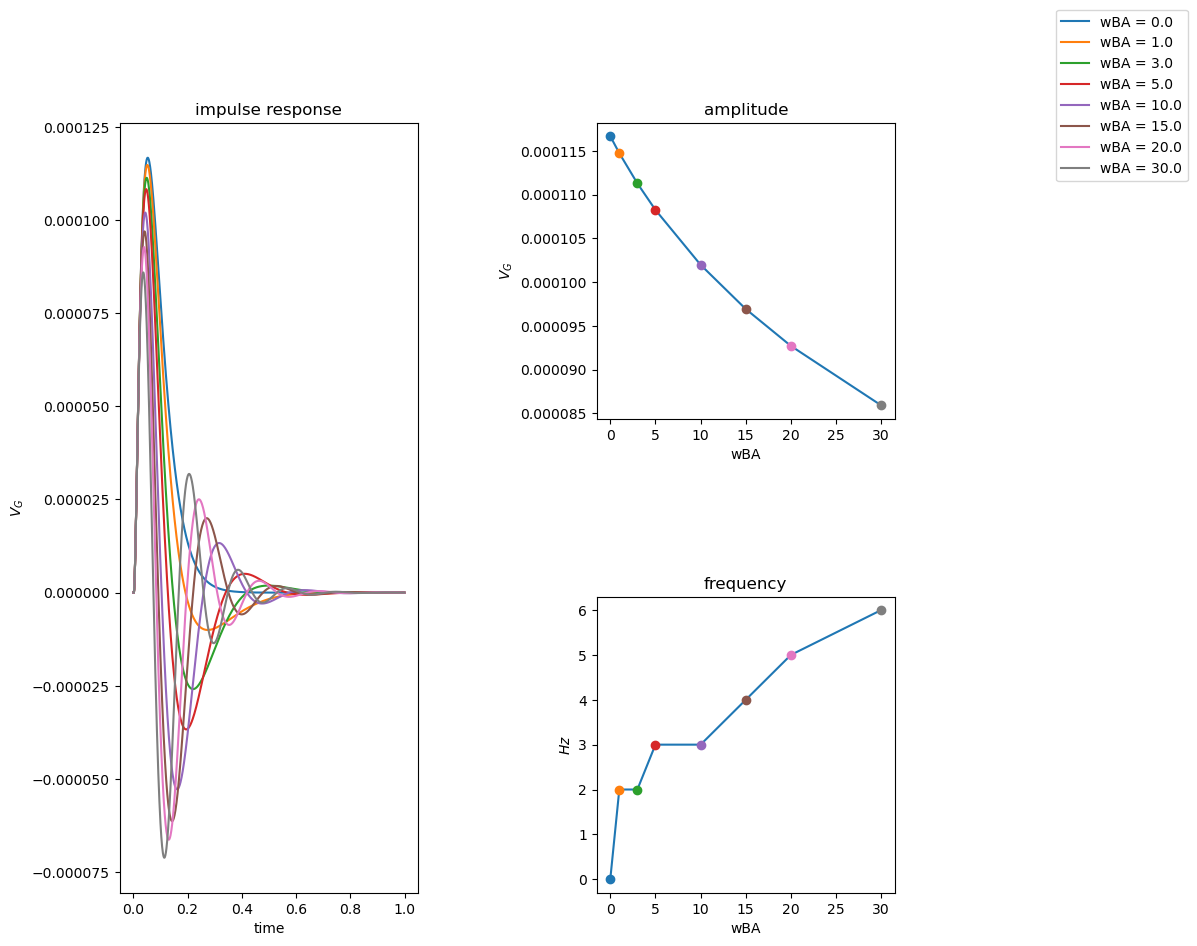

In [51]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



amp_w = []
freq_w = []
signal_w = []
for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  

    ax0.plot(time_impulse, out_impulse['VG'], label = f'wBA = {val}')

    amp_w.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_w.append(frequency)
    signal_w.append(out_impulse['VG'])

    ax1.scatter(val,amp_w[-1], zorder = 10)
    ax2.scatter(val,freq_w[-1], zorder = 10)


ax1.plot(vals_w,amp_w)
ax2.plot(vals_w,freq_w)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('wBA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('wBA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

# plot for multiple values of absolute time constants (keep distance between them same) SUPPLEMENTARY

-> the bigger the time constants the more the response becomes polyphasic 

-> the frequency stays constant 

-> the more the step reponse becomes transient ond oscillating

In [52]:
param = 'tauB'
vals = np.arange(0.03,0.14,0.01)
vals= np.round(vals,4)


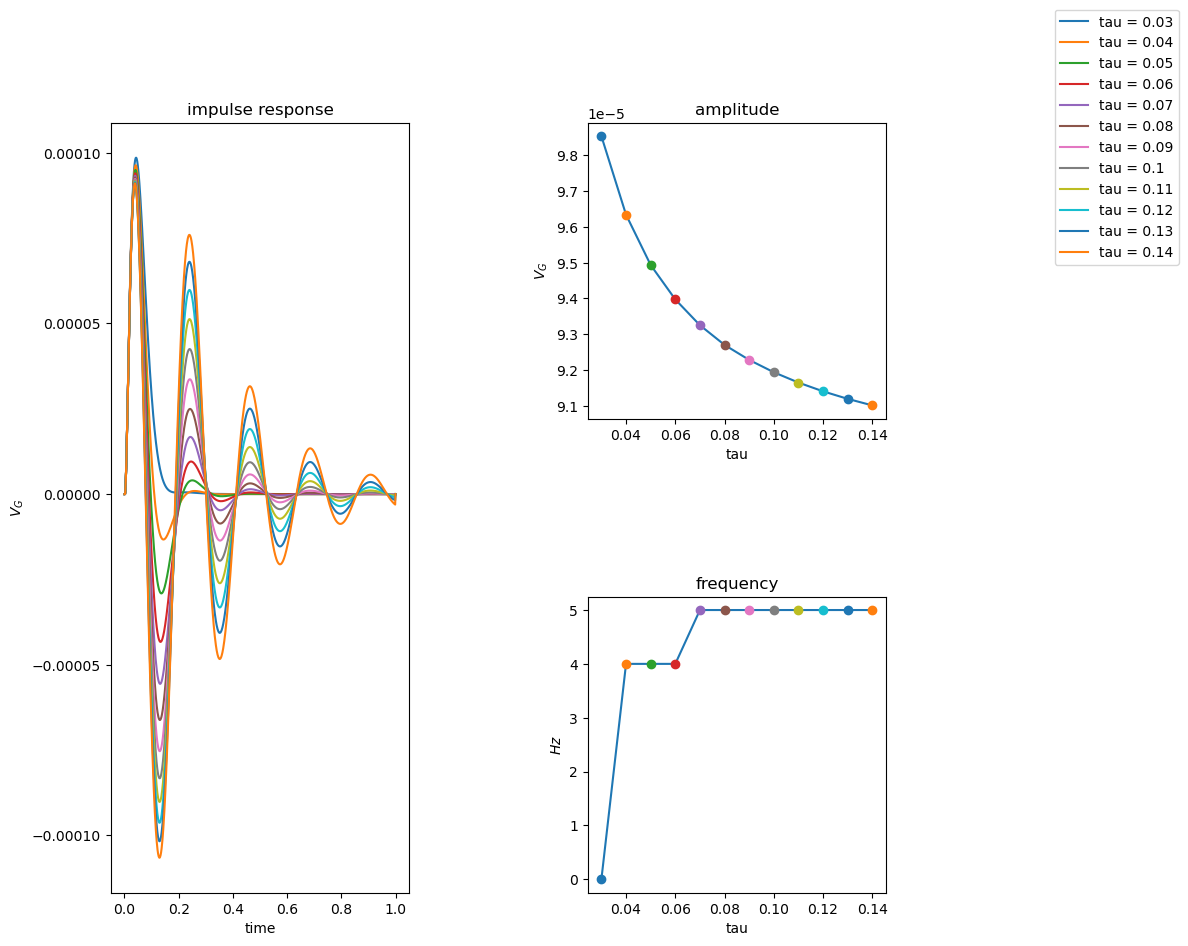

In [53]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



amp = []
freq = []
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  

    ax0.plot(time_impulse, out_impulse['VG'], label = f'tauB = {val}')

    amp.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq.append(frequency)
    ax1.scatter(val,amp[-1], zorder = 10)
    ax2.scatter(val,freq[-1], zorder = 10)


ax1.plot(vals,amp)
ax2.plot(vals,freq)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('tau')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('tau')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

# same for relative distance 

 -> only changes the amplitude 

In [54]:
param = 'tauA'
vals_tau = np.linspace(1.,10,10)
vals


array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13,
       0.14])

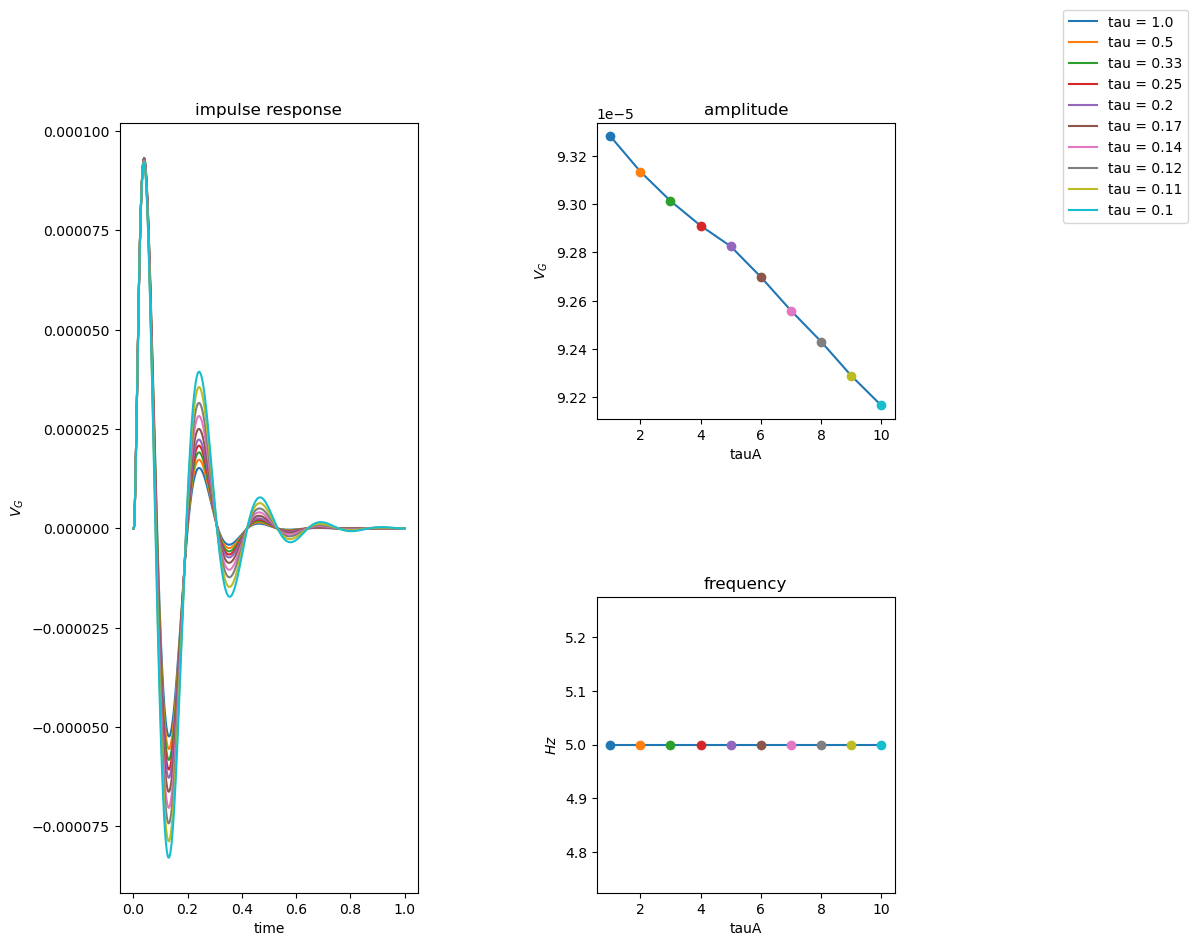

In [78]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



amp_tau = []
freq_tau = []
signal_tau = []
for i,val in enumerate(vals_tau): 
    x = val
    tauB = 0.08
    tauA =  np.round(1/(-x+1/tauB),2)
    # load output 
    with open(f'{fp}/{param}/{param}_{tauA}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  

    ax0.plot(time_impulse, out_impulse['VG'], label = f'tau = {np.round(1/val,2)}')

    amp_tau.append(np.max(out_impulse['VG']))

    frequency_tau = main_frequency( out_impulse['VG'], 1/params['dt'])
    signal_tau.append(out_impulse['VG'])
    freq_tau.append(frequency)
    ax1.scatter(val,amp_tau[-1], zorder = 10)
    ax2.scatter(val,freq_tau[-1], zorder = 10)


ax1.plot(vals_tau,amp_tau)
ax2.plot(vals_tau,freq_tau)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('tauA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('tauA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

In [56]:
# TODO figure with envelope to quantify damping ??
# TODO heatmap for implulse frequency and amplitude

In [77]:
params['wAB']

20.0

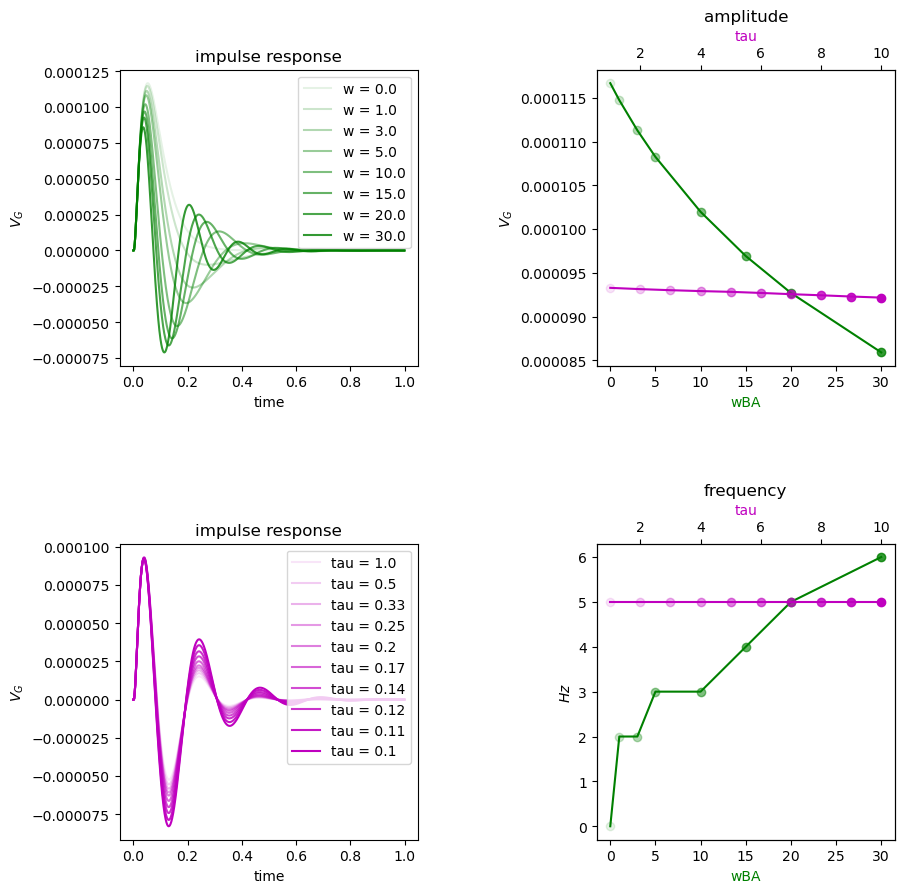

In [75]:
fig = plt.figure(figsize = (10,10))


gs = fig.add_gridspec(2,2)

ax0w = fig.add_subplot(gs[0,0])
ax0t = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[0,1])

ax1t = ax1.twiny()
ax2 = fig.add_subplot(gs[1,1])
ax2t = ax2.twiny()

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



for i,val in enumerate(vals_w): 

    x = val
 
    ax0w.plot(time_impulse, signal_w[i], label = f'w = {val*10.}', color = 'g', alpha = i*0.1+0.1)  # *10  because w = wB*wAB

    ax1.scatter(val,amp_w[i], zorder = 10, color = 'g', alpha = i*0.1+0.1)
    ax2.scatter(val,freq_w[i], zorder = 10, color = 'g', alpha = i*0.1+0.1)


for i,val in enumerate(vals_tau): 

    x = val
 
    ax0t.plot(time_impulse, signal_tau[i], label = f'tau = {np.round(1/val,2)}', color = 'm', alpha = i*0.1+0.1)

    ax1t.scatter(val,amp_tau[i], zorder = 10, color = 'm', alpha = i*0.1+0.1)
    ax2t.scatter(val,freq_tau[i], zorder = 10, color = 'm', alpha = i*0.1+0.1)


ax1t.plot(vals_tau,amp_tau, color = 'm')
ax2t.plot(vals_tau,freq_tau, color = 'm')

ax1.plot(vals_w,amp_w, color = 'g')
ax2.plot(vals_w,freq_w, color = 'g')
  
  
ax0w.set_xlabel('time')
ax0w.set_ylabel('$V_{G}$')
ax0w.set_title('impulse response')

ax0t.set_xlabel('time')
ax0t.set_ylabel('$V_{G}$')
ax0t.set_title('impulse response')



ax1.set_xlabel('w',color = 'g')
ax1t.set_xlabel('tau',color = 'm')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('w',color = 'g')
ax2t.set_xlabel('tau',color = 'm')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

ax0t.legend(loc = 'upper right')
ax0w.legend(loc = 'upper right')